<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/2.%20Hybrid%20supervised/GAN/src/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make directories to manage input and outpus

In [ ]:
!mkdir input
!mkdir outputs

## (optional) create a python file to store the resulting script later

In [ ]:
%%writefile vanilla_gan.py

Writing vanilla_gan.py


# Importing All the Required Modules and Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

# Defining the Learning Parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparing the Dataset

In [ ]:
# Define transform to convert the image to tensors and normalize them as well
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# Convert the images to the PIL image format (required for the .gif)
to_pil_image = transforms.ToPILImage()

# Training dataset
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)

# Training data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# The Generator Neural Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# The Discriminator Neural Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# Initialize the Neural Networks and Define the Optimizers

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function (binary cross-entropy)
criterion = nn.BCELoss()

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# Defining Some Auxiliary Functions

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

## Function to train the discriminator

In [ ]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

## Function to train the generator

In [ ]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss

# Training the Vanilla GAN

In [ ]:
# create the noise vector
noise = create_noise(sample_size, nz)

# Switch both the networks to training mode before moving ahead
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

## The Training Loop

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:20,  5.63it/s]                         


Epoch 0 of 200
Generator loss: 1.33263946, Discriminator loss: 0.90576935


118it [00:15,  7.79it/s]                         


Epoch 1 of 200
Generator loss: 1.77584553, Discriminator loss: 1.47085893


118it [00:15,  7.85it/s]                         


Epoch 2 of 200
Generator loss: 5.86757278, Discriminator loss: 0.21888457


118it [00:15,  7.77it/s]                         


Epoch 3 of 200
Generator loss: 3.91076398, Discriminator loss: 1.02282405


118it [00:16,  7.09it/s]                         


Epoch 4 of 200
Generator loss: 2.89097333, Discriminator loss: 1.12091792


118it [00:15,  7.74it/s]                         


Epoch 5 of 200
Generator loss: 4.42074251, Discriminator loss: 0.65761232


118it [00:15,  7.77it/s]                         


Epoch 6 of 200
Generator loss: 3.48653078, Discriminator loss: 0.76621336


118it [00:15,  7.84it/s]                         


Epoch 7 of 200
Generator loss: 3.93891120, Discriminator loss: 0.92271990


118it [00:15,  7.60it/s]                         


Epoch 8 of 200
Generator loss: 2.52617931, Discriminator loss: 0.98397970


118it [00:15,  7.67it/s]                         


Epoch 9 of 200
Generator loss: 1.97714233, Discriminator loss: 0.98196399


118it [00:14,  7.88it/s]                         


Epoch 10 of 200
Generator loss: 2.00051379, Discriminator loss: 0.84896463


118it [00:15,  7.80it/s]                         


Epoch 11 of 200
Generator loss: 1.94236636, Discriminator loss: 1.02194905


118it [00:15,  7.82it/s]                         


Epoch 12 of 200
Generator loss: 3.28758025, Discriminator loss: 0.91166991


118it [00:15,  7.64it/s]                         


Epoch 13 of 200
Generator loss: 1.49577212, Discriminator loss: 1.06980908


118it [00:14,  7.95it/s]                         


Epoch 14 of 200
Generator loss: 2.65405607, Discriminator loss: 0.91384006


118it [00:14,  7.90it/s]                         


Epoch 15 of 200
Generator loss: 2.18737721, Discriminator loss: 0.94669414


118it [00:15,  7.84it/s]                         


Epoch 16 of 200
Generator loss: 2.68504286, Discriminator loss: 0.85064656


118it [00:15,  7.52it/s]                         


Epoch 17 of 200
Generator loss: 1.78700387, Discriminator loss: 0.97297573


118it [00:15,  7.85it/s]                         


Epoch 18 of 200
Generator loss: 2.75505304, Discriminator loss: 0.60537142


118it [00:15,  7.84it/s]                         


Epoch 19 of 200
Generator loss: 3.60801435, Discriminator loss: 0.60346764


118it [00:15,  7.83it/s]                         


Epoch 20 of 200
Generator loss: 2.49238443, Discriminator loss: 0.71487874


118it [00:15,  7.51it/s]                         


Epoch 21 of 200
Generator loss: 3.03650904, Discriminator loss: 0.56058550


118it [00:14,  7.88it/s]                         


Epoch 22 of 200
Generator loss: 3.10633302, Discriminator loss: 0.64053750


118it [00:14,  7.89it/s]                         


Epoch 23 of 200
Generator loss: 3.36802363, Discriminator loss: 0.50091261


118it [00:14,  7.95it/s]                         


Epoch 24 of 200
Generator loss: 3.94595575, Discriminator loss: 0.37226039


118it [00:15,  7.62it/s]                         


Epoch 25 of 200
Generator loss: 3.58526707, Discriminator loss: 0.53017592


118it [00:15,  7.71it/s]                         


Epoch 26 of 200
Generator loss: 3.77334905, Discriminator loss: 0.36356521


118it [00:14,  7.96it/s]                         


Epoch 27 of 200
Generator loss: 4.05515623, Discriminator loss: 0.33458203


118it [00:14,  8.00it/s]                         


Epoch 28 of 200
Generator loss: 3.72047615, Discriminator loss: 0.40975973


118it [00:14,  7.94it/s]                         


Epoch 29 of 200
Generator loss: 3.91235232, Discriminator loss: 0.45556900


118it [00:15,  7.74it/s]                         


Epoch 30 of 200
Generator loss: 3.95815444, Discriminator loss: 0.36370713


118it [00:14,  7.98it/s]                         


Epoch 31 of 200
Generator loss: 3.43193245, Discriminator loss: 0.42975217


118it [00:14,  7.99it/s]                         


Epoch 32 of 200
Generator loss: 3.04418969, Discriminator loss: 0.49490580


118it [00:14,  7.96it/s]                         


Epoch 33 of 200
Generator loss: 3.41657519, Discriminator loss: 0.41231474


118it [00:15,  7.69it/s]                         


Epoch 34 of 200
Generator loss: 3.37744856, Discriminator loss: 0.43006721


118it [00:15,  7.86it/s]                         


Epoch 35 of 200
Generator loss: 3.39269376, Discriminator loss: 0.50082070


118it [00:14,  7.89it/s]                         


Epoch 36 of 200
Generator loss: 2.80882359, Discriminator loss: 0.51260668


118it [00:15,  7.79it/s]                         


Epoch 37 of 200
Generator loss: 3.48650789, Discriminator loss: 0.34545717


118it [00:15,  7.67it/s]                         


Epoch 38 of 200
Generator loss: 3.52980661, Discriminator loss: 0.42141345


118it [00:15,  7.72it/s]                         


Epoch 39 of 200
Generator loss: 3.17929006, Discriminator loss: 0.47797260


118it [00:14,  8.00it/s]                         


Epoch 40 of 200
Generator loss: 3.18613219, Discriminator loss: 0.45416480


118it [00:14,  8.03it/s]


Epoch 41 of 200
Generator loss: 3.63419652, Discriminator loss: 0.35362390


118it [00:14,  7.99it/s]                         


Epoch 42 of 200
Generator loss: 3.45759988, Discriminator loss: 0.42127103


118it [00:15,  7.53it/s]                         


Epoch 43 of 200
Generator loss: 3.03990364, Discriminator loss: 0.51031303


118it [00:14,  8.01it/s]                         


Epoch 44 of 200
Generator loss: 3.35265970, Discriminator loss: 0.46311057


118it [00:14,  7.96it/s]                         


Epoch 45 of 200
Generator loss: 3.10179305, Discriminator loss: 0.47570422


118it [00:14,  8.00it/s]                         


Epoch 46 of 200
Generator loss: 3.10348821, Discriminator loss: 0.46092156


118it [00:15,  7.59it/s]                         


Epoch 47 of 200
Generator loss: 3.14975047, Discriminator loss: 0.45409107


118it [00:14,  7.87it/s]                         


Epoch 48 of 200
Generator loss: 3.12654901, Discriminator loss: 0.40968028


118it [00:15,  7.85it/s]                         


Epoch 49 of 200
Generator loss: 3.24761200, Discriminator loss: 0.42271206


118it [00:14,  7.96it/s]                         


Epoch 50 of 200
Generator loss: 3.06241822, Discriminator loss: 0.47512820


118it [00:14,  7.95it/s]                         


Epoch 51 of 200
Generator loss: 2.98893881, Discriminator loss: 0.53167182


118it [00:15,  7.68it/s]                         


Epoch 52 of 200
Generator loss: 3.18329406, Discriminator loss: 0.45348111


118it [00:14,  7.94it/s]                         


Epoch 53 of 200
Generator loss: 3.07211614, Discriminator loss: 0.45166200


118it [00:14,  7.94it/s]                         


Epoch 54 of 200
Generator loss: 3.17664719, Discriminator loss: 0.45320949


118it [00:14,  8.02it/s]                         


Epoch 55 of 200
Generator loss: 3.04456258, Discriminator loss: 0.50466835


118it [00:15,  7.74it/s]                         


Epoch 56 of 200
Generator loss: 2.86154747, Discriminator loss: 0.50140870


118it [00:14,  7.91it/s]                         


Epoch 57 of 200
Generator loss: 2.90787196, Discriminator loss: 0.53013992


118it [00:14,  7.89it/s]                         


Epoch 58 of 200
Generator loss: 2.73618841, Discriminator loss: 0.55264592


118it [00:14,  7.96it/s]                         


Epoch 59 of 200
Generator loss: 2.86456203, Discriminator loss: 0.54203695


118it [00:14,  8.06it/s]                         


Epoch 60 of 200
Generator loss: 2.70188355, Discriminator loss: 0.50577319


118it [00:15,  7.68it/s]                         


Epoch 61 of 200
Generator loss: 2.70032358, Discriminator loss: 0.52290887


118it [00:14,  8.01it/s]                         


Epoch 62 of 200
Generator loss: 2.66854215, Discriminator loss: 0.52534515


118it [00:14,  7.92it/s]                         


Epoch 63 of 200
Generator loss: 2.66928792, Discriminator loss: 0.56327677


118it [00:14,  8.07it/s]                         


Epoch 64 of 200
Generator loss: 2.70429397, Discriminator loss: 0.53364140


118it [00:14,  7.88it/s]                         


Epoch 65 of 200
Generator loss: 2.66048288, Discriminator loss: 0.51957846


118it [00:14,  7.88it/s]                         


Epoch 66 of 200
Generator loss: 2.70970130, Discriminator loss: 0.53686839


118it [00:14,  8.02it/s]                         


Epoch 67 of 200
Generator loss: 2.80278659, Discriminator loss: 0.54987496


118it [00:14,  7.91it/s]                         


Epoch 68 of 200
Generator loss: 2.79061985, Discriminator loss: 0.54815245


118it [00:14,  7.96it/s]                         


Epoch 69 of 200
Generator loss: 2.64731884, Discriminator loss: 0.54806340


118it [00:15,  7.63it/s]                         


Epoch 70 of 200
Generator loss: 2.74776125, Discriminator loss: 0.56909931


118it [00:15,  7.86it/s]                         


Epoch 71 of 200
Generator loss: 2.50291181, Discriminator loss: 0.59220803


118it [00:14,  8.06it/s]                         


Epoch 72 of 200
Generator loss: 2.44678283, Discriminator loss: 0.61314994


118it [00:14,  8.14it/s]                         


Epoch 73 of 200
Generator loss: 2.42901921, Discriminator loss: 0.62124032


118it [00:15,  7.78it/s]                         


Epoch 74 of 200
Generator loss: 2.49294639, Discriminator loss: 0.60223854


118it [00:15,  7.74it/s]                         


Epoch 75 of 200
Generator loss: 2.48533893, Discriminator loss: 0.61901456


118it [00:14,  7.95it/s]                         


Epoch 76 of 200
Generator loss: 2.46395445, Discriminator loss: 0.62658942


118it [00:14,  7.97it/s]                         


Epoch 77 of 200
Generator loss: 2.38424683, Discriminator loss: 0.64620620


118it [00:14,  7.98it/s]                         


Epoch 78 of 200
Generator loss: 2.34632421, Discriminator loss: 0.66673392


118it [00:15,  7.55it/s]                         


Epoch 79 of 200
Generator loss: 2.35645556, Discriminator loss: 0.64843762


118it [00:14,  7.98it/s]                         


Epoch 80 of 200
Generator loss: 2.30769038, Discriminator loss: 0.68310654


118it [00:14,  7.98it/s]                         


Epoch 81 of 200
Generator loss: 2.24072051, Discriminator loss: 0.68459749


118it [00:14,  8.05it/s]                         


Epoch 82 of 200
Generator loss: 2.20425129, Discriminator loss: 0.69006783


118it [00:14,  7.99it/s]                         


Epoch 83 of 200
Generator loss: 2.15216160, Discriminator loss: 0.71681100


118it [00:15,  7.80it/s]                         


Epoch 84 of 200
Generator loss: 2.22334981, Discriminator loss: 0.71109927


118it [00:14,  8.02it/s]                         


Epoch 85 of 200
Generator loss: 2.11436367, Discriminator loss: 0.69411659


118it [00:14,  7.95it/s]                         


Epoch 86 of 200
Generator loss: 2.15361118, Discriminator loss: 0.71378213


118it [00:14,  8.01it/s]                         


Epoch 87 of 200
Generator loss: 2.30059648, Discriminator loss: 0.69945496


118it [00:15,  7.78it/s]                         


Epoch 88 of 200
Generator loss: 2.15744996, Discriminator loss: 0.69637442


118it [00:14,  7.88it/s]                         


Epoch 89 of 200
Generator loss: 2.33027697, Discriminator loss: 0.63913530


118it [00:14,  7.89it/s]                         


Epoch 90 of 200
Generator loss: 2.32924199, Discriminator loss: 0.66423970


118it [00:14,  7.97it/s]


Epoch 91 of 200
Generator loss: 2.35689855, Discriminator loss: 0.67489743


118it [00:14,  7.96it/s]                         


Epoch 92 of 200
Generator loss: 2.25194931, Discriminator loss: 0.69685376


118it [00:15,  7.67it/s]                         


Epoch 93 of 200
Generator loss: 2.10655069, Discriminator loss: 0.70726413


118it [00:14,  7.94it/s]                         


Epoch 94 of 200
Generator loss: 2.06818652, Discriminator loss: 0.72225666


118it [00:14,  7.98it/s]                         


Epoch 95 of 200
Generator loss: 2.12472510, Discriminator loss: 0.73887902


118it [00:14,  8.00it/s]                         


Epoch 96 of 200
Generator loss: 1.97616839, Discriminator loss: 0.77646607


118it [00:15,  7.73it/s]                         


Epoch 97 of 200
Generator loss: 1.93393111, Discriminator loss: 0.77273178


118it [00:14,  7.87it/s]                         


Epoch 98 of 200
Generator loss: 1.95736718, Discriminator loss: 0.74229795


118it [00:14,  7.99it/s]                         


Epoch 99 of 200
Generator loss: 2.02892375, Discriminator loss: 0.77322567


118it [00:14,  8.02it/s]                         


Epoch 100 of 200
Generator loss: 2.04550648, Discriminator loss: 0.78333086


118it [00:14,  7.98it/s]                         


Epoch 101 of 200
Generator loss: 1.93837607, Discriminator loss: 0.79749060


118it [00:15,  7.71it/s]                         


Epoch 102 of 200
Generator loss: 1.96428955, Discriminator loss: 0.79250014


118it [00:14,  7.91it/s]                         


Epoch 103 of 200
Generator loss: 1.98733544, Discriminator loss: 0.79495007


118it [00:14,  8.05it/s]                         


Epoch 104 of 200
Generator loss: 1.91666579, Discriminator loss: 0.79382765


118it [00:14,  8.07it/s]                         


Epoch 105 of 200
Generator loss: 1.91104543, Discriminator loss: 0.83587068


118it [00:15,  7.67it/s]                         


Epoch 106 of 200
Generator loss: 1.90089166, Discriminator loss: 0.82470042


118it [00:15,  7.59it/s]                         


Epoch 107 of 200
Generator loss: 1.90683579, Discriminator loss: 0.80697113


118it [00:14,  7.94it/s]                         


Epoch 108 of 200
Generator loss: 1.93744063, Discriminator loss: 0.80448437


118it [00:15,  7.83it/s]                         


Epoch 109 of 200
Generator loss: 1.96535099, Discriminator loss: 0.79712617


118it [00:15,  7.82it/s]                         


Epoch 110 of 200
Generator loss: 1.97180688, Discriminator loss: 0.77587986


118it [00:15,  7.47it/s]                         


Epoch 111 of 200
Generator loss: 1.87732625, Discriminator loss: 0.84309632


118it [00:15,  7.76it/s]                         


Epoch 112 of 200
Generator loss: 1.81608880, Discriminator loss: 0.84947425


118it [00:14,  7.89it/s]                         


Epoch 113 of 200
Generator loss: 1.97139716, Discriminator loss: 0.78339887


118it [00:14,  7.91it/s]                         


Epoch 114 of 200
Generator loss: 1.92966402, Discriminator loss: 0.80090618


118it [00:15,  7.47it/s]                         


Epoch 115 of 200
Generator loss: 2.00201607, Discriminator loss: 0.77159226


118it [00:14,  7.90it/s]                         


Epoch 116 of 200
Generator loss: 1.88049650, Discriminator loss: 0.84783673


118it [00:14,  7.89it/s]                         


Epoch 117 of 200
Generator loss: 1.74434781, Discriminator loss: 0.85744655


118it [00:15,  7.85it/s]


Epoch 118 of 200
Generator loss: 1.87492371, Discriminator loss: 0.82950580


118it [00:15,  7.49it/s]                         


Epoch 119 of 200
Generator loss: 1.87335777, Discriminator loss: 0.82721120


118it [00:15,  7.85it/s]                         


Epoch 120 of 200
Generator loss: 1.86279464, Discriminator loss: 0.83033609


118it [00:14,  7.94it/s]                         


Epoch 121 of 200
Generator loss: 1.88885081, Discriminator loss: 0.83066255


118it [00:14,  7.92it/s]                         


Epoch 122 of 200
Generator loss: 1.87858987, Discriminator loss: 0.81672680


118it [00:15,  7.62it/s]                         


Epoch 123 of 200
Generator loss: 1.82838261, Discriminator loss: 0.85292369


118it [00:15,  7.83it/s]                         


Epoch 124 of 200
Generator loss: 1.80752170, Discriminator loss: 0.88653642


118it [00:15,  7.81it/s]                         


Epoch 125 of 200
Generator loss: 1.74239421, Discriminator loss: 0.86773628


118it [00:14,  7.92it/s]                         


Epoch 126 of 200
Generator loss: 1.72308624, Discriminator loss: 0.86141753


118it [00:15,  7.83it/s]                         


Epoch 127 of 200
Generator loss: 1.76571381, Discriminator loss: 0.84902078


118it [00:15,  7.54it/s]                         


Epoch 128 of 200
Generator loss: 1.73170567, Discriminator loss: 0.88383049


118it [00:14,  7.88it/s]                         


Epoch 129 of 200
Generator loss: 1.63772857, Discriminator loss: 0.90054125


118it [00:14,  7.87it/s]                         


Epoch 130 of 200
Generator loss: 1.66163194, Discriminator loss: 0.92249954


118it [00:15,  7.83it/s]                         


Epoch 131 of 200
Generator loss: 1.65628994, Discriminator loss: 0.89828670


118it [00:15,  7.59it/s]                         


Epoch 132 of 200
Generator loss: 1.62396586, Discriminator loss: 0.94338065


118it [00:15,  7.83it/s]                         


Epoch 133 of 200
Generator loss: 1.70030761, Discriminator loss: 0.90496832


118it [00:15,  7.78it/s]                         


Epoch 134 of 200
Generator loss: 1.70126474, Discriminator loss: 0.90745288


118it [00:15,  7.80it/s]                         


Epoch 135 of 200
Generator loss: 1.61383033, Discriminator loss: 0.92263770


118it [00:15,  7.53it/s]                         


Epoch 136 of 200
Generator loss: 1.65659189, Discriminator loss: 0.90560740


118it [00:14,  7.89it/s]                         


Epoch 137 of 200
Generator loss: 1.61934173, Discriminator loss: 0.94641590


118it [00:15,  7.84it/s]                         


Epoch 138 of 200
Generator loss: 1.58481073, Discriminator loss: 0.93105453


118it [00:15,  7.79it/s]                         


Epoch 139 of 200
Generator loss: 1.59165907, Discriminator loss: 0.93787116


118it [00:15,  7.82it/s]                         


Epoch 140 of 200
Generator loss: 1.48521245, Discriminator loss: 0.97483981


118it [00:15,  7.78it/s]                         


Epoch 141 of 200
Generator loss: 1.57746422, Discriminator loss: 0.94113153


118it [00:14,  8.02it/s]                         


Epoch 142 of 200
Generator loss: 1.53965902, Discriminator loss: 0.96589559


118it [00:14,  7.89it/s]                         


Epoch 143 of 200
Generator loss: 1.54566026, Discriminator loss: 0.96278858


118it [00:14,  8.00it/s]                         


Epoch 144 of 200
Generator loss: 1.53845167, Discriminator loss: 0.97119731


118it [00:15,  7.63it/s]                         


Epoch 145 of 200
Generator loss: 1.52429867, Discriminator loss: 0.95738244


118it [00:14,  7.94it/s]                         


Epoch 146 of 200
Generator loss: 1.55004251, Discriminator loss: 0.93908006


118it [00:15,  7.86it/s]                         


Epoch 147 of 200
Generator loss: 1.56933379, Discriminator loss: 0.94262964


118it [00:14,  7.95it/s]                         


Epoch 148 of 200
Generator loss: 1.57489228, Discriminator loss: 0.96482229


118it [00:14,  7.87it/s]                         


Epoch 149 of 200
Generator loss: 1.51268661, Discriminator loss: 0.97343212


118it [00:15,  7.71it/s]                         


Epoch 150 of 200
Generator loss: 1.47130048, Discriminator loss: 0.99175197


118it [00:14,  7.88it/s]                         


Epoch 151 of 200
Generator loss: 1.58500266, Discriminator loss: 0.95273757


118it [00:14,  8.00it/s]                         


Epoch 152 of 200
Generator loss: 1.53052843, Discriminator loss: 0.97313046


118it [00:14,  7.98it/s]                         


Epoch 153 of 200
Generator loss: 1.51632273, Discriminator loss: 0.96859443


118it [00:15,  7.50it/s]                         


Epoch 154 of 200
Generator loss: 1.60078895, Discriminator loss: 0.94562769


118it [00:15,  7.79it/s]                         


Epoch 155 of 200
Generator loss: 1.57129502, Discriminator loss: 0.95770824


118it [00:14,  7.88it/s]                         


Epoch 156 of 200
Generator loss: 1.53994703, Discriminator loss: 0.96843529


118it [00:15,  7.79it/s]                         


Epoch 157 of 200
Generator loss: 1.51148760, Discriminator loss: 0.97203398


118it [00:15,  7.52it/s]                         


Epoch 158 of 200
Generator loss: 1.49859273, Discriminator loss: 0.99084371


118it [00:15,  7.74it/s]                         


Epoch 159 of 200
Generator loss: 1.50196815, Discriminator loss: 0.97450542


118it [00:15,  7.79it/s]                         


Epoch 160 of 200
Generator loss: 1.48300958, Discriminator loss: 0.99442232


118it [00:15,  7.73it/s]                         


Epoch 161 of 200
Generator loss: 1.46996725, Discriminator loss: 0.98486429


118it [00:15,  7.40it/s]                         


Epoch 162 of 200
Generator loss: 1.46951413, Discriminator loss: 1.01155567


118it [00:15,  7.71it/s]                         


Epoch 163 of 200
Generator loss: 1.44834495, Discriminator loss: 0.98851693


118it [00:15,  7.82it/s]                         


Epoch 164 of 200
Generator loss: 1.47864032, Discriminator loss: 0.99919575


118it [00:15,  7.72it/s]                         


Epoch 165 of 200
Generator loss: 1.51265395, Discriminator loss: 0.98511922


118it [00:15,  7.52it/s]                         


Epoch 166 of 200
Generator loss: 1.48276186, Discriminator loss: 0.99032491


118it [00:15,  7.63it/s]                         


Epoch 167 of 200
Generator loss: 1.47516501, Discriminator loss: 0.99918240


118it [00:15,  7.85it/s]                         


Epoch 168 of 200
Generator loss: 1.47336352, Discriminator loss: 0.99311280


118it [00:15,  7.79it/s]                         


Epoch 169 of 200
Generator loss: 1.42177820, Discriminator loss: 1.00362444


118it [00:15,  7.50it/s]                         


Epoch 170 of 200
Generator loss: 1.46971464, Discriminator loss: 0.99603653


118it [00:15,  7.57it/s]                         


Epoch 171 of 200
Generator loss: 1.44103432, Discriminator loss: 1.00661600


118it [00:15,  7.84it/s]                         


Epoch 172 of 200
Generator loss: 1.45469701, Discriminator loss: 1.00561941


118it [00:15,  7.82it/s]                         


Epoch 173 of 200
Generator loss: 1.37579691, Discriminator loss: 1.03240931


118it [00:15,  7.59it/s]                         


Epoch 174 of 200
Generator loss: 1.39072680, Discriminator loss: 1.02833068


118it [00:15,  7.51it/s]                         


Epoch 175 of 200
Generator loss: 1.40243828, Discriminator loss: 1.03567648


118it [00:15,  7.68it/s]                         


Epoch 176 of 200
Generator loss: 1.43876541, Discriminator loss: 1.01267409


118it [00:15,  7.83it/s]                         


Epoch 177 of 200
Generator loss: 1.39932692, Discriminator loss: 1.02441347


118it [00:15,  7.65it/s]                         


Epoch 178 of 200
Generator loss: 1.39125967, Discriminator loss: 1.03666186


118it [00:15,  7.55it/s]                         


Epoch 179 of 200
Generator loss: 1.36603141, Discriminator loss: 1.02900898


118it [00:15,  7.81it/s]                         


Epoch 180 of 200
Generator loss: 1.35798430, Discriminator loss: 1.04602134


118it [00:15,  7.65it/s]                         


Epoch 181 of 200
Generator loss: 1.33895552, Discriminator loss: 1.06026912


118it [00:15,  7.76it/s]                         


Epoch 182 of 200
Generator loss: 1.30750144, Discriminator loss: 1.05955982


118it [00:15,  7.50it/s]                         


Epoch 183 of 200
Generator loss: 1.39493263, Discriminator loss: 1.05288923


118it [00:15,  7.77it/s]                         


Epoch 184 of 200
Generator loss: 1.36662602, Discriminator loss: 1.04497433


118it [00:15,  7.79it/s]                         


Epoch 185 of 200
Generator loss: 1.35025513, Discriminator loss: 1.05810416


118it [00:15,  7.78it/s]                         


Epoch 186 of 200
Generator loss: 1.35253894, Discriminator loss: 1.05968714


118it [00:15,  7.39it/s]                         


Epoch 187 of 200
Generator loss: 1.32137668, Discriminator loss: 1.06159163


118it [00:15,  7.69it/s]                         


Epoch 188 of 200
Generator loss: 1.34773922, Discriminator loss: 1.04608154


118it [00:15,  7.72it/s]                         


Epoch 189 of 200
Generator loss: 1.37293601, Discriminator loss: 1.05057156


118it [00:15,  7.65it/s]                         


Epoch 190 of 200
Generator loss: 1.33556962, Discriminator loss: 1.04409134


118it [00:15,  7.61it/s]                         


Epoch 191 of 200
Generator loss: 1.35182476, Discriminator loss: 1.04823494


118it [00:15,  7.77it/s]                         


Epoch 192 of 200
Generator loss: 1.35492122, Discriminator loss: 1.04460454


118it [00:15,  7.68it/s]                         


Epoch 193 of 200
Generator loss: 1.32428098, Discriminator loss: 1.06636012


118it [00:15,  7.67it/s]                         


Epoch 194 of 200
Generator loss: 1.29746640, Discriminator loss: 1.07693708


118it [00:15,  7.64it/s]                         


Epoch 195 of 200
Generator loss: 1.31593585, Discriminator loss: 1.06008792


118it [00:15,  7.79it/s]                         


Epoch 196 of 200
Generator loss: 1.30652297, Discriminator loss: 1.07247746


118it [00:15,  7.77it/s]                         


Epoch 197 of 200
Generator loss: 1.31249082, Discriminator loss: 1.07396841


118it [00:15,  7.81it/s]                         


Epoch 198 of 200
Generator loss: 1.31050134, Discriminator loss: 1.07278693


118it [00:15,  7.54it/s]                         

Epoch 199 of 200
Generator loss: 1.30120063, Discriminator loss: 1.07488227


# Visualizing and saving the results

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

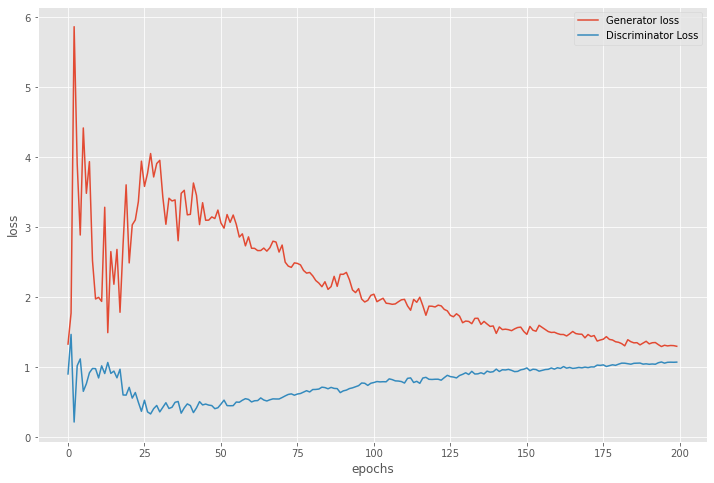

In [22]:
# plot and save the generator and discriminator loss
plt.figure(figsize=(12,8))
plt.plot([losses_g[i].cpu().detach().numpy() for i in range (len(losses_g))], label='Generator loss')
plt.plot([losses_d[i].cpu().detach().numpy() for i in range (len(losses_d))], label='Discriminator Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('outputs/loss.png')

In [ ]:
from IPython.display import Image
Image(open('outputs/generator_images.gif', 'rb').read())